# Analyze Methods
This notebook demonstrates how to train and evaluate the classifiers for sentence-level target identification.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pickle
import warnings

In [3]:
# Set this to true if you want to load the pickle files
LOAD_PREV_EVAL=False

## Below are all of the local imports

In [4]:
import sys
sys.path.append("..")

In [101]:
import sentence_annotation.evaluate as evaluate
import sentence_annotation.novel_methods as novel_methods
import sentence_annotation.standard_methods as standard_methods
import sentence_annotation.alignment as alignment

## Load the word2vec models

In order to run this notebook, you must download the pre-trained word2vec model, which is available for download at:
http://yuca.test.iminds.be:8900/fgodin/downloads/word2vec_twitter_model.tar.gz

In [26]:
import word2vec
import word2vecReader

# The location of the .bin file is specific to where you downloaded the file (of course)
w2v_tweets = word2vecReader.Word2Vec.load_word2vec_format("/mnt/bd2/word2vec_twitter_model/word2vec_twitter_model.bin",binary=True)

### Train and Evaluate Standard Models (or load previous)

In [52]:
if not LOAD_PREV_EVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_results_rf = evaluate.evaluate_method(standard_methods.create_pipeline_bow_rf(),training_data_dir="training_data")
        open("results/eval_results_rf.pkl","wb").write(pickle.dumps(eval_results_rf))
        eval_results_nb = evaluate.evaluate_method(standard_methods.create_pipeline_bow_nb(),training_data_dir="training_data")
        open("results/eval_results_nb.pkl","wb").write(pickle.dumps(eval_results_nb))
        eval_results_svm = evaluate.evaluate_method(standard_methods.create_pipeline_bow_svm(),training_data_dir="training_data")
        open("results/eval_results_svm.pkl","wb").write(pickle.dumps(eval_results_svm))
        eval_results_alignment_v1 = evaluate.evaluate_method(novel_methods.create_pipeline_alignment_v1(w2v_tweets),training_data_dir="training_data")
        open("results/eval_results_alignment_v1.pkl","wb").write(pickle.dumps(eval_results_svm))
else:
    eval_results_rf = pickle.load(open("results/eval_results_rf.pkl","rb"))
    eval_results_svm = pickle.load(open("results/eval_results_svm.pkl","rb"))
    eval_results_nb = pickle.load(open("results/eval_results_nb.pkl","rb"))


Evaluating tweets
Evaluating tweets
Evaluating tweets


In [133]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_results_max = evaluate.evaluate_method(novel_methods.create_pipeline(w2v_tweets,novel_methods.get_max_distance_metric),training_data_dir="training_data")

Evaluating tweets


In [134]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_results_mean = evaluate.evaluate_method(novel_methods.create_pipeline(w2v_tweets,novel_methods.get_mean_distance_metric),training_data_dir="training_data")

Evaluating tweets


In [126]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    alignment_method = alignment.Alignment(w2v_tweets)
    eval_results_alignment_v1 = evaluate.evaluate_method(novel_methods.create_pipeline(alignment_method,novel_methods.get_alignment_distance_metric),training_data_dir="training_data")

Evaluating tweets


In [129]:
eval_results_alignment_v1

{'tweets': {2: array([0.66137566, 0.54459203, 0.60261438, 0.64567955, 0.55299335,
         0.46784922, 0.33063428, 0.33063428, 0.56231003, 0.56231003,
         0.58041958, 0.58222629, 0.42527716, 0.50337382, 0.45351044,
         0.64444444, 0.51042129, 0.58222629, 0.58041958, 0.52857143]),
  3: array([0.66618287, 0.64132554, 0.64615385, 0.52530713, 0.45626478,
         0.51809524, 0.60571429, 0.4619883 , 0.64952381, 0.73461538,
         0.65151515, 0.55110426, 0.67252017, 0.67001435, 0.4565999 ,
         0.60192308, 0.50682261, 0.64132554, 0.62677485, 0.53794643]),
  4: array([0.61183186, 0.47276688, 0.4989648 , 0.51648352, 0.74883238,
         0.49425287, 0.56282876, 0.47700258, 0.62947368, 0.63561077,
         0.63561077, 0.58787879, 0.61343669, 0.52248062, 0.58315789,
         0.53939394, 0.49052632, 0.61426067, 0.63333333, 0.54166667]),
  5: array([0.68602645, 0.62566845, 0.57045455, 0.61111111, 0.61556064,
         0.45207033, 0.59500851, 0.43673469, 0.58941921, 0.58941921,
      

In [118]:
print('here')

here


In [55]:
import matplotlib.pyplot as plt

def create_plots(labels,eval_results_array,names,metric_label="Metric",outfile=None):    
    linestyles = ['-', '--', '-.', ':','-']

    auc = {}
    plt.figure()
    #plt.title(label.replace("_"," "))
    plt.ylabel(metric_label)
    plt.xlabel('Training Size')

    for label in labels:
        auc[label] = []
        for i,eval_results in enumerate(eval_results_array):
            auc[label].append({})
            training_sizes = np.sort(list(eval_results[label].keys()))
            means = []
            sderrs = []
            for sz in training_sizes:
                means.append(np.mean(eval_results[label][sz]))                
                sderrs.append(np.std(eval_results[label][sz])/np.sqrt(len(eval_results[label][sz])))

            #plt.errorbar(training_sizes, means, yerr=sderrs, fmt='o')
            try:
                plt.plot(training_sizes, means, linestyle=linestyles[i])
            except:
                import pdb
                pdb.set_trace()

            lower_bound_means = np.array(means)-1.96*np.array(sderrs)
            upper_bound_means = np.array(means)+1.96*np.array(sderrs)
            auc[label][i]["lower"] = np.trapz(lower_bound_means,x=training_sizes*1./np.max(training_sizes))
            auc[label][i]["upper"] = np.trapz(upper_bound_means,x=training_sizes*1./np.max(training_sizes))
            auc[label][i]["average"] = (auc[label][i]["lower"]+auc[label][i]["upper"])/2.

    plt.legend(names)
    if outfile:
        plt.savefig(outfile, bbox_inches='tight')

    return auc


In [135]:
names = ["SVM","RF","Alignment","Max","Mean"]
statistics = [eval_results_svm,eval_results_rf,eval_results_alignment_v1,eval_results_max,eval_results_mean]

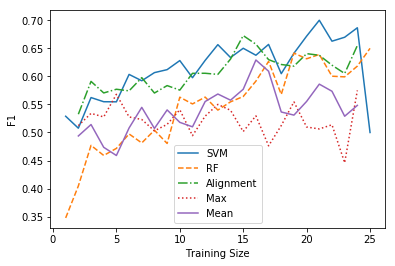

In [136]:
auc = create_plots(['tweets'],statistics,names,metric_label="F1")

In [130]:
eval_results_alignment_v1

{'tweets': {2: array([0.66137566, 0.54459203, 0.60261438, 0.64567955, 0.55299335,
         0.46784922, 0.33063428, 0.33063428, 0.56231003, 0.56231003,
         0.58041958, 0.58222629, 0.42527716, 0.50337382, 0.45351044,
         0.64444444, 0.51042129, 0.58222629, 0.58041958, 0.52857143]),
  3: array([0.66618287, 0.64132554, 0.64615385, 0.52530713, 0.45626478,
         0.51809524, 0.60571429, 0.4619883 , 0.64952381, 0.73461538,
         0.65151515, 0.55110426, 0.67252017, 0.67001435, 0.4565999 ,
         0.60192308, 0.50682261, 0.64132554, 0.62677485, 0.53794643]),
  4: array([0.61183186, 0.47276688, 0.4989648 , 0.51648352, 0.74883238,
         0.49425287, 0.56282876, 0.47700258, 0.62947368, 0.63561077,
         0.63561077, 0.58787879, 0.61343669, 0.52248062, 0.58315789,
         0.53939394, 0.49052632, 0.61426067, 0.63333333, 0.54166667]),
  5: array([0.68602645, 0.62566845, 0.57045455, 0.61111111, 0.61556064,
         0.45207033, 0.59500851, 0.43673469, 0.58941921, 0.58941921,
      

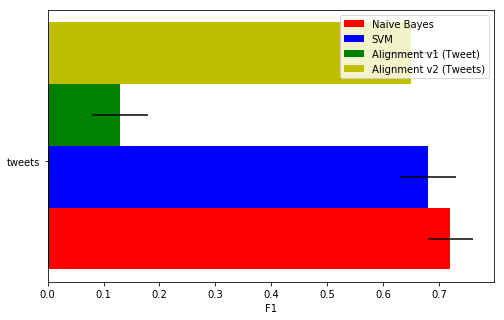

In [22]:
N = 0
labels = []
F1_scores = []
for label, value in auc.items():
    N = N + 1
    labels.append(label)
    F1_scores.append(-1.*auc[label][3]["average"])

inxs = np.argsort(F1_scores)
labels = list(np.array(labels)[inxs])
        
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

rects = []
colors = ["r","b","g","y","c"]            
for i in range(len(names)):
    means = []
    errors = []
    for label in labels:
        lower = np.round(100*auc[label][i]["lower"])/100
        upper = np.round(100*auc[label][i]["upper"])/100
        average = np.round(100*auc[label][i]["average"])/100
        means.append(average)
        errors.append(upper-average)
    
    rects.append(ax.barh(ind + width*(i-1), means,width, color=colors[i], xerr=errors))

# add some text for labels, title and axes ticks
ax.set_xlabel('F1')
#ax.set_title('Scores by group and gender')
ax.set_yticks(ind + width / len(names))
ax.set_yticklabels(labels)

legend_ref = []
for rect in rects:
    legend_ref.append(rect[0])
ax.legend(legend_ref, names)


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)

plt.savefig('results/f1_images/histogram.png', bbox_inches='tight')
plt.show()


### Code to generate the latex table

In [23]:
first = True
for label in labels:
        if first:
            print("Category",end="")
            print(" & ",end="")
            print("\# Samples",end="")
            for i in range(len(names)):
                print(" & ",end="")
                print(names[i],end="")
            print(" \\\\ \hline")
            first = False

        plabel = label.replace("_"," ")
        plabel = plabel.replace("NeighborhoodArea ","")
        plabel = plabel.replace("Interior ","")
        plabel = plabel.replace("PropertyLot ","")
        plabel = plabel.replace("Community ","")
        print(plabel,end="")
        print(" & ",end="")
        print(len(statistics[0][label].keys()),end="")
        for i in range(len(names)):
            print(" & ",end="")
            lower = np.round(100*auc[label][i]["lower"])/100
            upper = np.round(100*auc[label][i]["upper"])/100
            print(str(lower)+" - "+str(upper),end="")
        
        print("\\\\")

Category & \# Samples & Naive Bayes & SVM & Alignment v1 (Tweet) & Alignment v2 (Tweets) \\ \hline
tweets & 25 & 0.68 - 0.76 & 0.63 - 0.73 & 0.08 - 0.18 & 0.6 - 0.7\\
